In [1]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from imutils import perspective
from imutils import contours
import argparse
import imutils
from scipy.spatial import distance as dist

In [2]:
def order_points_old(pts):
    # initialize a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

# ap = argparse.ArgumentParser()
# # ap.add_argument("-n", "--new", type=int, default=-1,
# #     help="whether or not the new order points should should be used")
# args = vars(ap.parse_args())

In [3]:
img = cv2.imread("mu-ba-6-1-638.jpg")

img = imutils.rotate_bound(img, 30)
  
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
im_gray = cv2.GaussianBlur(img_gray, (1,1),0)
edged = cv2.Canny(im_gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=1)
edged = cv2.erode(edged, None, iterations=1)

Object #1:
[[ 552 1035]
 [  -2  714]
 [ 412   -2]
 [ 966  317]]
value 4 coor [[ 412   -2]
 [ 966  317]
 [ 552 1035]
 [  -2  714]]



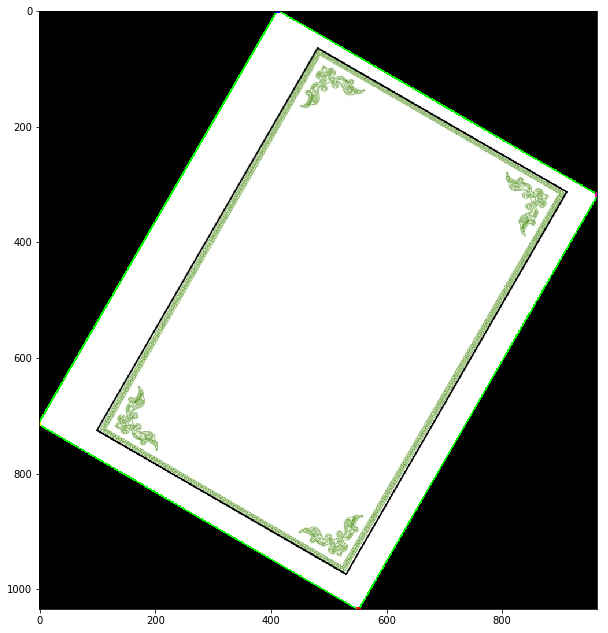

In [4]:
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# sort the contours from left-to-right and initialize the bounding box
# point colors
(cnts, _) = contours.sort_contours(cnts)
colors = ((0, 0, 255), (240, 0, 159), (255, 0, 0), (255, 255, 0))

for (i, c) in enumerate(cnts):
    # if the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue

    # compute the rotated bounding box of the contour, then
    # draw the contours
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    cv2.drawContours(img, [box], -1, (0, 255, 0), 2)

    # show the original coordinates
    print("Object #{}:".format(i + 1))
    print(box)
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    rect = order_points_old(box)

    # check to see if the new method should be used for
    # ordering the coordinates
#     if args["new"] > 0:
#         rect = perspective.order_points(box)

    # show the re-ordered coordinates
    print("value 4 coors", rect.astype("int"))
    print("")
    
    
    # loop over the original points and draw them
    for ((x, y), color) in zip(rect, colors):
        cv2.circle(img, (int(x), int(y)), 5, color, -1)

    # draw the object num at the top-left corner
    cv2.putText(img, "Object #{}".format(i + 1),
        (int(rect[0][0] - 15), int(rect[0][1] - 15)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)

    # show the image
    plt.figure(figsize=(10,20))
    plt.imshow(img)
plt.show()